## import packages

In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from pathlib import Path
import os

## set up for imports of .py modules by adding path to sys.path

In [2]:
path = Path(os.getcwd())
path = str(path)
print(path)
sys.path.insert(1, path)

/home/peter/Desktop/DS5220/Labs/lecture_1_lab_2/lecture_1_lab_2


## import python modules

In [3]:
import utils.lecture_1_lab_2_utils as utils

## helpful functions

In [4]:
def plot_pred_vs_actual(pred_y_df, train_y_df, data_set_name):
    plt.scatter(train_y_df, pred_y_df)  # plot predicted y vs true y
    plt.plot(train_y_df, train_y_df, 'b')  # plot a line of slope 1 demonstrating perfect predictions
    plt.grid()
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(data_set_name)
    plt.show()

## parameters

In [5]:
path_to_data = 'modified_fara_pima_ds5220.csv'
target_attr = 'age'
test_size = 0.20
train_test_split_random_state = 42
missingness_threshold = 0.20

## set up to time script run time

In [6]:
start = time.time()

## read in the data and get the size of the data. note that this data set is a moddified version of the pima data set.

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [7]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(768, 8)


,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0
1,1.0,85.0,66.0,29.0,0.0,NaN,0.351,31.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0


## 1. check for missingness in target vector

### we are going to regress age on the other attributes - since age is the response we drop all observations for which age is equal to nan - never impute the target

In [8]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(768, 8)
(760, 8)


## 2. train/test split

### save the train and test set. delete the test set data frame and the original data frame so there is no way they can be used in training.

In [9]:
train_cap_x_df, train_y_df = utils.perform_the_train_test_split(df, test_size, train_test_split_random_state, val=False)

*************************

df.shape:
(760, 8)

*************************

train_df.csv:
(608, 7) (608, 1)

*************************

test_df.csv
(152, 7) (152, 1)


In [10]:
del df

In [11]:
train_cap_x_df.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes
701,6.0,125.0,78.0,31.0,0.0,27.6,0.565
363,4.0,146.0,78.0,0.0,0.0,38.5,0.520
267,2.0,128.0,64.0,42.0,0.0,40.0,1.101
90,1.0,80.0,55.0,0.0,0.0,19.1,0.258
370,3.0,173.0,82.0,48.0,465.0,38.4,2.137


In [12]:
train_y_df.head()

,age
701,49.0
363,67.0
267,24.0
90,21.0
370,25.0


## 3. train/validation split

### The Scikit-learn LinearRegression API does not have model flexibility hyperparameters therefore we will not be tuning hyper parameters in this modeling effort. As a result a validation data set is not required so we will skip the train/validation split step.

## 4. check out the attribute types

In [13]:
train_cap_x_df.dtypes

pregnant     float64
glucose      float64
diastolic    float64
triceps      float64
insulin      float64
bmi          float64
diabetes     float64
dtype: object

## 5. identify attributes with  missingness above threshold

In [14]:
missingness_drop_list = []
for attr in train_cap_x_df.columns:
    attr_missingness = train_cap_x_df[attr].isna().sum() / train_cap_x_df.shape[0]
    print(f'{attr} missingness = {attr_missingness}')
    if attr_missingness >= missingness_threshold:
        missingness_drop_list.append(attr)

print(f'\nmissingness_drop_list:\n{missingness_drop_list}')

pregnant missingness = 0.029605263157894735
glucose missingness = 0.008223684210526315
diastolic missingness = 0.21217105263157895
triceps missingness = 0.11019736842105263
insulin missingness = 0.023026315789473683
bmi missingness = 0.05098684210526316
diabetes missingness = 0.013157894736842105

missingness_drop_list:
['diastolic']


## 6. identify non machine learning attributes

### these are attributes that are not meaningful to machine learning - examples include observation identification attributes, etc. - enter these into the non_ml_attr_list manually. note that this step is typically informed from an eda conducted in a separate notebook.

In [15]:
train_cap_x_df.columns

Index(['pregnant', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi',
       'diabetes'],
      dtype='object')

In [16]:
non_ml_attr_list = []  # no non-machine learning attributes were identified

## 7. identify attributes to exclude from machine learning

### identify attributes that were candidates for machine learning but you have chosen to eliminate from machine learning - elimination can be due to low variance, etc. - enter these into the ml_attr_drop_list manually. note that this step is typically informed from an eda conducted in a separate notebook.

In [17]:
train_cap_x_df.columns

Index(['pregnant', 'glucose', 'diastolic', 'triceps', 'insulin', 'bmi',
       'diabetes'],
      dtype='object')

In [18]:
ml_attr_drop_list = []  # none were identified

## 8. establish machine learning attribute configuration

### Note that you should not modify the loaded data frame. This confioguration will be used in a Scikit-learn pipeline to control which attributes are used in the machine learning process.

In [19]:
ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
ml_ignore_list

['diastolic']

In [20]:
train_cap_x_df.dtypes

pregnant     float64
glucose      float64
diastolic    float64
triceps      float64
insulin      float64
bmi          float64
diabetes     float64
dtype: object

In [21]:
# identify the remaining numerical attributes to be used in machine learning and enter them into the 
# numerical_attr list below.

numerical_attr = ['pregnant', 'glucose', 'triceps', 'insulin', 'bmi', 'diabetes']

# identify the remaining nominal attributes to be used in machine learning and enter them into the 
# nominal_attr list below.

nominal_attr = []

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print(f'ml_ignore_list: {ml_ignore_list}')
print(f'\nnumerical_attr: {numerical_attr}')
print(f'nominal_attr: {numerical_attr}')

print(f'\nnumber of machine learning attributes: {len(numerical_attr) + len(nominal_attr)}')
print(f'\nnumerical_attr and nominal_attr: {numerical_attr + nominal_attr}')

ml_ignore_list: ['diastolic']

numerical_attr: ['pregnant', 'glucose', 'triceps', 'insulin', 'bmi', 'diabetes']
nominal_attr: ['pregnant', 'glucose', 'triceps', 'insulin', 'bmi', 'diabetes']

number of machine learning attributes: 6

numerical_attr and nominal_attr: ['pregnant', 'glucose', 'triceps', 'insulin', 'bmi', 'diabetes']


## 9. build a composite estimator

### define the estimators involved in the experiment

In [22]:
estimator_names = ['LinearRegression']

estimator_list = [
    LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
]

### build a numerical transformer that will impute missing values and scale the attributes

In [23]:
numerical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer()),
           ("scaler", StandardScaler())]
)

### build a preprocessor - note that typically the column transformer will have a pipeline for nominal attributes also. since there are no nomial attributes in this data set we do not need a nominal transformer

In [24]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attr),
        ]
    )

### assemble the preprocessor and the predictor into a composite estimator

In [25]:
composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator_list[0])])

## 10. survey (fit and evaluate)  default composite estimators

### since we are only working with one estimator our survey is over just one estimator

### fit the composite estimator

In [26]:
composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['pregnant', 'glucose',
                                                   'triceps', 'insulin', 'bmi',
                                                   'diabetes'])])),
                ('estimator', LinearRegression())])

### check out the regression coefficients and the intercept

In [27]:
# what are the estimated coefficients for the linear regression problem

composite_estimator[1].coef_

array([ 5.82305355,  2.6708124 , -1.29987742, -0.40047377, -0.07438465,
        0.36152325])

In [28]:
# what is the intercept of the linear regression problem

composite_estimator[1].intercept_

33.338815789473685

In [29]:
# access the attribute names going into the estimator step of the pipeline

composite_estimator[0].get_feature_names_out()

array(['numerical__pregnant', 'numerical__glucose', 'numerical__triceps',
       'numerical__insulin', 'numerical__bmi', 'numerical__diabetes'],
      dtype=object)

In [30]:
# make a dictionary that has the attribute names as keys and the corresponding estimated coefficients for the linear regression problem
# as values

names = ['intercept'] + [attr_name.split('_')[2] for attr_name in composite_estimator[0].get_feature_names_out()]
coef_values = [composite_estimator[1].intercept_] + list(composite_estimator[1].coef_)
lin_reg_parameters_dict = dict(zip(names, coef_values))

lin_reg_parameters_dict

{'intercept': 33.338815789473685,
 'pregnant': 5.823053550360502,
 'glucose': 2.6708124021311472,
 'triceps': -1.299877416444645,
 'insulin': -0.4004737672266158,
 'bmi': -0.07438464926520721,
 'diabetes': 0.3615232466878715}

### Note that these are equal to those found using the stasmodel OLS API. 

### evaluate the training error using root mean squared error (rmse)

In [31]:
train_rmse = root_mean_squared_error(train_y_df, composite_estimator.predict(train_cap_x_df))
print(f'train_rmse: {train_rmse}')

print(f'relative train_rmse: {train_rmse/np.mean(train_y_df)}')

train_rmse: 9.573609937595291
relative train_rmse: 0.2871610676890941


### evaluate the model using rmse and n-fold cross validation on the train set

The following code randomly splits the training set into 5 nonoverlapping subsets called folds, then it trains and evaluates the linear regression model 5 times, picking a different fold for evaluation every time and using the other 4 folds for training. The result is an array containing the 5 evaluation scores.

In [32]:
cv_rmse = cross_val_score(
    estimator=composite_estimator, 
    X=train_cap_x_df,
    y=train_y_df.values.ravel(),
    groups=None, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    n_jobs=None, 
    verbose=0, 
    fit_params=None, 
    params=None, 
    pre_dispatch='2*n_jobs', 
    error_score=np.nan
)
cv_rmse = -1 * cv_rmse
cv_rmse

array([ 9.4825901 ,  9.93474717,  9.05794328, 10.71342621,  9.3684998 ])

In [33]:
print(f'estimated model rmse: {np.mean(cv_rmse)}')
print(f'precision of estimated model rmse: {np.std(cv_rmse, ddof=1)}')

estimated model rmse: 9.711441312338717
precision of estimated model rmse: 0.6424330064450535


### plot predicted vs actual

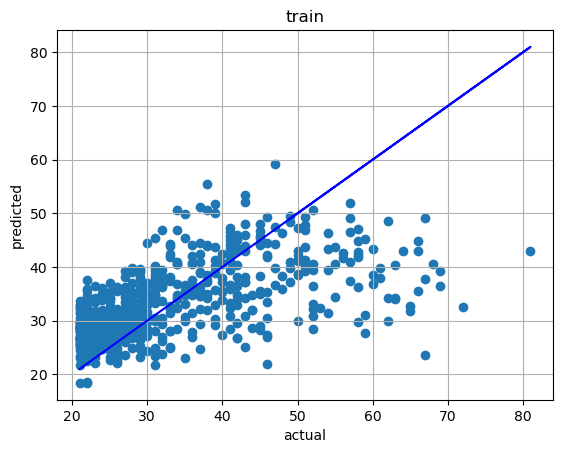

In [34]:
plot_pred_vs_actual(composite_estimator.predict(train_cap_x_df), train_y_df, 'train')

## 11. short list default composite estimators

### Note that since we are only working with one estimator there is no reason to short list

## 12. tune hyperparameters of short-listed composite estimators

### Note that the statsmodels OLS API does not have any model flexibility hyper parameters so we cannot tune the estimator.

## 13. evaluate tuned composite estimators

### Note that the statsmodels OLS API does not have any model flexibility hyper parameters so we cannot evaluate a tuned estimator.

## 14. check for false discoveries

### This is an advanced topic and will be covered latter in the course.

## 15. select a model

### Model selection is trivial as we only have one model in this modeling effort.

## 16. evaluate generalization -  make predictions on the test set with the model

### load the test set

In [35]:
test_df = pd.read_csv('test_df.csv', index_col='index')
test_df.index.name = None
test_df.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age
397,0.0,131.0,66.0,40.0,0.0,34.3,0.196,22.0
325,1.0,157.0,NaN,21.0,168.0,25.6,0.123,24.0
97,1.0,71.0,48.0,18.0,76.0,20.4,0.323,22.0
502,6.0,0.0,68.0,41.0,0.0,39.0,0.727,41.0
109,0.0,95.0,NaN,25.0,36.0,37.4,0.247,24.0


### break test_df apart into the design matrix (test_cap_x_df) and the target vector (test_y_df) then delete test_df

In [36]:
test_cap_x_df = test_df.iloc[:, :-1]
test_cap_x_df.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes
397,0.0,131.0,66.0,40.0,0.0,34.3,0.196
325,1.0,157.0,NaN,21.0,168.0,25.6,0.123
97,1.0,71.0,48.0,18.0,76.0,20.4,0.323
502,6.0,0.0,68.0,41.0,0.0,39.0,0.727
109,0.0,95.0,NaN,25.0,36.0,37.4,0.247


In [37]:
test_y_df = test_df.iloc[:, -1].to_frame()
test_y_df.head()

,age
397,22.0
325,24.0
97,22.0
502,41.0
109,24.0


In [38]:
del test_df

### evaluate the model on the test data using the rmse metric

In [39]:
test_rmse = root_mean_squared_error(test_y_df, composite_estimator.predict(test_cap_x_df))
print(f'test_rmse: {test_rmse}')

print(f'relative test_rmse: {test_rmse/np.mean(test_y_df)}')

test_rmse: 9.51250840928766
relative test_rmse: 0.28620373677983457


### summary of results

| 5-fold cv on train (rmse) | test rmse |
|:-------------------------:|:---------:|
|       9.7 +/- 0.6         |    9.5    |

### Since the test set rmse of 9.5 falls within the train set 5-fold cv precision band (9.1 to 10.3) on the train set we can conclude that we are not overfitting the model. It is possible that a more flexible model might provide better predictions (lower rmse).

## check out script run time

In [40]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 0.006210402647654215 minutes
